## Importing libraries

In [ ]:
!pip install torch torchmetrics torchaudio datasets transformers scikit-learn matplotlib wandb torchcodec

from datasets import load_dataset
from transformers import (
    AutoFeatureExtractor,
    AutoModelForAudioClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import librosa
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)
from google.colab import drive
import os
from google.colab import userdata
import torch
import wandb

## Getting paths for metadata and getting a key for wandb

In [2]:
BASE_DIR = '/content/'
TRAIN_PATH = os.path.join(BASE_DIR, 'train.csv')
VALID_PATH = os.path.join(BASE_DIR, 'valid.csv')
TEST_PATH  = os.path.join(BASE_DIR, 'test.csv')

wandb_kay = userdata.get('WANDB')

## Log in to wandb

In [ ]:
wandb.login(key=wandb_kay)

wandb.init(
    project="Hubert",
)


## Cloning your google drive

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


## Selecting the target directory

In [5]:
!rsync -a "/content/drive/MyDrive/audio_cls/" .

## Downloading a dataset

In [ ]:
dataset = load_dataset(
    "csv",
    data_files={
        "train": TRAIN_PATH,
        "valid": VALID_PATH,
        "test" : TEST_PATH
    }
)
dataset

## Fix paths for a google colab

In [ ]:
DATA_DIR_TRAIN = "/content/train"
DATA_DIR_VALID = "/content/valid"
DATA_DIR_TEST  = "/content/test"

def fix_path_train(example):
    example["path"] = f"{DATA_DIR_TRAIN}/{example["path"]}"
    return example

def fix_path_valid(example):
    example["path"] = f"{DATA_DIR_VALID}/{example["path"]}"
    return example

def fix_path_test(example):
    example["path"] = f"{DATA_DIR_TEST}/{example["path"]}"
    return example

def fix_label(example):
    example["labels"] = example.pop("target")
    return example

train_df = dataset['train']
valid_df = dataset['valid']
test_df  = dataset['test']

train_df = train_df.map(fix_path_train)
valid_df = valid_df.map(fix_path_valid)
test_df  = test_df.map(fix_path_test)

train_df = train_df.map(fix_label)
valid_df = valid_df.map(fix_label)
test_df  = test_df.map(fix_label)


## Initial model

In [ ]:
MODEL_NAME = "facebook/hubert-base-ls960"
NUM_LABELS = 4

feature_extractor = AutoFeatureExtractor.from_pretrained(MODEL_NAME)

model = AutoModelForAudioClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    ignore_mismatched_sizes=True
)

## Downloading audio samples

In [9]:
import numpy as np

TARGET_LEN = 16000 * 8

def preprocess(batch):
    waveform, sr = librosa.load(batch["path"], sr=16000)
    if len(waveform) < TARGET_LEN:
        waveform = np.pad(waveform, (0, TARGET_LEN - len(waveform)))
    else:
        waveform = waveform[:TARGET_LEN]
    inputs = feature_extractor(
        waveform,
        sampling_rate=16000,
        return_tensors="pt"
    )

    input_values = inputs["input_values"].squeeze(0)
    labels = torch.tensor(batch["labels"], dtype=torch.long)

    return {"input_values": input_values, "labels": labels}

train_df = train_df.map(preprocess)
valid_df = valid_df.map(preprocess)
test_df = test_df.map(preprocess)

Map:   0%|          | 0/480 [00:00<?, ? examples/s]

Map:   0%|          | 0/96 [00:00<?, ? examples/s]

Map:   0%|          | 0/105 [00:00<?, ? examples/s]

## Implement metrics computing

In [10]:
def compute_metrics_hf(eval_pred):
    logits, labels = eval_pred
    logits = torch.tensor(logits)
    labels = torch.tensor(labels).long()
    probs = torch.nn.functional.softmax(logits, dim=-1)
    preds = probs.argmax(dim=-1)
    labels_np = labels.cpu().numpy()
    preds_np = preds.cpu().numpy()
    return {
        "accuracy": accuracy_score(labels_np, preds_np),
        "f1_macro": f1_score(labels_np, preds_np, average="macro"),
        "precision_macro": precision_score(labels_np, preds_np, average="macro"),
        "recall_macro": recall_score(labels_np, preds_np, average="macro"),
    }

## Implement a data collator

In [11]:
def collate_fn(features):
    xs = torch.stack(
        [torch.tensor(f["input_values"], dtype=torch.float32) for f in features]
    )
    labels = torch.tensor([f["labels"] for f in features], dtype=torch.long)
    return {"input_values": xs, "labels": labels}

## Initial a training config

In [ ]:

train_batch_size = 20
val_batch_size = 12
EPOCHS = 200


early_stopping = EarlyStoppingCallback(
    early_stopping_patience=5,
    early_stopping_threshold=0.0
)

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=train_batch_size,
    per_device_eval_batch_size=val_batch_size,
    num_train_epochs=EPOCHS,
    eval_strategy="steps",
    save_steps=10,
    eval_steps=10,
    logging_strategy="steps",
    logging_steps=10,
    report_to="wandb",
    fp16=False,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_df,
    eval_dataset=valid_df,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics_hf,
    data_collator=collate_fn,
    callbacks=[early_stopping]
)

## Training a model

In [13]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
10,1.313300,1.169582,0.406250,0.213670,0.207753,0.296218
20,1.211700,1.019984,0.614583,0.510500,0.791261,0.516457
30,1.027400,0.851876,0.833333,0.831423,0.856914,0.833508
40,0.958900,0.738310,0.854167,0.865064,0.876180,0.873030
50,0.757200,0.588327,0.916667,0.924985,0.931115,0.925026
60,0.701600,0.505392,0.885417,0.886193,0.922674,0.875000
70,0.729200,0.539740,0.843750,0.855849,0.884050,0.853714
80,0.572100,0.416507,0.895833,0.897214,0.914931,0.887328
90,0.499400,0.376983,0.916667,0.919051,0.911189,0.929753
100,0.463200,0.334594,0.927083,0.924260,0.946396,0.910962


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=160, training_loss=0.6852709412574768, metrics={'train_runtime': 1710.376, 'train_samples_per_second': 56.128, 'train_steps_per_second': 2.806, 'total_flos': 2.324142587904e+17, 'train_loss': 0.6852709412574768, 'epoch': 6.666666666666667})

In [14]:
trainer.save_model("./results/best_model")
feature_extractor.save_pretrained("./results/best_model")
artifact = wandb.Artifact("best_model", type="model")
artifact.add_dir("./results/best_model")
wandb.log_artifact(artifact)


wandb: Adding directory to artifact (results/best_model)... Done. 11.5s


<Artifact best_model>

In [15]:
predictions_output = trainer.predict(test_df)
print("Метрики на тесті:")
for k, v in predictions_output.metrics.items():
    print(f"{k}: {v:.4f}")
logits = predictions_output.predictions
probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1)
preds = probs.argmax(dim=-1).numpy()
labels = predictions_output.label_ids

Метрики на тесті:
test_loss: 0.3179
test_accuracy: 0.9238
test_f1_macro: 0.9225
test_precision_macro: 0.9186
test_recall_macro: 0.9274
test_runtime: 10.0522
test_samples_per_second: 10.4450
test_steps_per_second: 0.8950


In [16]:
wrong_idx = np.where(preds != labels)[0]

print(f"Кількість помилок: {len(wrong_idx)}")
print("Перші 10 помилкових прикладів:")
for i in wrong_idx[:10]:
    print(f"Index {i}: true={labels[i]}, pred={preds[i]}, probs={probs[i].tolist()}")

Кількість помилок: 8
Перші 10 помилкових прикладів:
Index 3: true=3, pred=2, probs=[0.012677045539021492, 0.04592633619904518, 0.878631055355072, 0.06276552379131317]
Index 16: true=3, pred=0, probs=[0.5402422547340393, 0.029591744765639305, 0.019386757165193558, 0.41077920794487]
Index 26: true=3, pred=0, probs=[0.8052765130996704, 0.034334804862737656, 0.013149475678801537, 0.14723923802375793]
Index 54: true=2, pred=3, probs=[0.06428638100624084, 0.020683204755187035, 0.10491061955690384, 0.8101197481155396]
Index 60: true=2, pred=3, probs=[0.04460405930876732, 0.02187453769147396, 0.18609566986560822, 0.7474256753921509]
Index 66: true=2, pred=1, probs=[0.04603695496916771, 0.8585875630378723, 0.073062002658844, 0.02231358177959919]
Index 87: true=1, pred=3, probs=[0.11847846210002899, 0.12100408226251602, 0.11226577311754227, 0.6482515931129456]
Index 102: true=0, pred=3, probs=[0.20589137077331543, 0.023509373888373375, 0.03685416653752327, 0.7337450981140137]


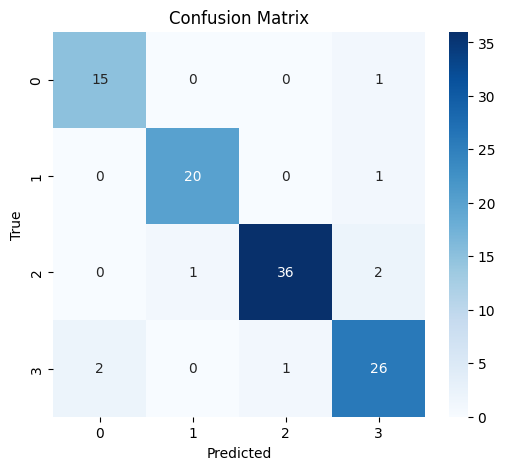

In [17]:
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()